# Homework 6: Regression and Sparsity
#### Camille Zaug
#### Monday, December 14, 2020

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import StandardScaler
from sklearn.utils import check_random_state
from sklearn.datasets import fetch_openml

import numpy as np
import matplotlib.pyplot as plt
import random
import scipy
import operator
import cvxopt
import l1regls

## Import and process the data

The following MNIST data is taken from the following source.

Author: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  

Source: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown 

We use the Python command `fetch_openml` from the `sklearn` package to load the data. The results are:
- `A` A matrix with the vectorized MNIST images. There are 70,000 images.
- `y1` A vector of all the labels (values between 0 and 9)

We then form a matrix `B` out of the labels in `y1` such that "1" = $\mathbf{e}_1$, "2" = $\mathbf{e}_2$, etc.

In [ ]:
A, y1 = fetch_openml("mnist_784", version=1, return_X_y=True)

In [ ]:
B = np.zeros((10,len(y1)),dtype =int)
k = 0
for label in y1:
    label = int(label)
    y = np.zeros((10,))
    
    if label <= 9:
        y[label-1] = 1
    
    elif label == 0:
        y[9] = 1
        print(y[9])        
        
    B[:,k]=y
    k+=1
B = np.transpose(B)

Let's plot some example images. Three examples are shown below.

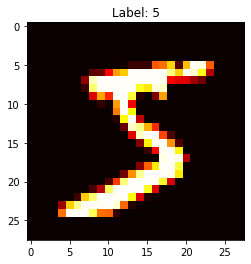

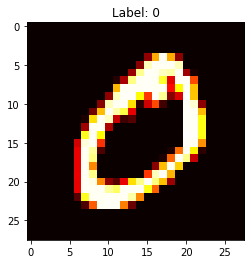

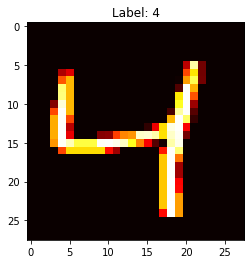

In [440]:
for i in range(3):
    u1 = X[i,:]
    u = np.reshape(u1, (28,28))
    plt.imshow(u,cmap = "hot", interpolation = 'nearest')
    plt.title("Label: "+y1[i])
    plt.show()

Next, we will split the data set to generate training and testing data. We reserve 30% of the data for testing.

In [ ]:
A_train, A_test, B_train, B_test = train_test_split(A,B, train_size=train_samples, test_size=0.3)

In [563]:
B_train.shape

(49000, 10)

## 1. Using various $\mathbf{A}\mathbf{X} =  \mathbf{B}$ solvers, determine a mapping from the image space to the label space

Note that in order to have the correct dimensions, $\mathbf{A}$ and $\mathbf{B}$ are the transposes of their definitions in the homework, so

$$
\mathbf{A} = \begin{bmatrix} \mathbf{x}_1 \\ \mathbf{x}_2 \\ \mathbf{x}_3 \\ \vdots \\ \mathbf{x}_n \\ \end{bmatrix}
$$

and

$$
\mathbf{B} = \begin{bmatrix} \mathbf{y}_1 \\ \mathbf{y}_2 \\ \mathbf{y}_3 \\ \vdots \\ \mathbf{y}_n \\ \end{bmatrix}.
$$

There are 70,000 images in this dataset, so $\mathbf{A}$ is a $70000 \times 784$ matrix and $\mathbf{B}$ is a  $70000 \times 10$ matrix.

Below, we use 5 unique models to determine a mapping from the image space to the pixel space. These models include:

- Pseudoinverse of $\mathbf{A}$
- Least squares linear regression
- The lasso
- Ridge regression
- Elastic net

Of these models, the lasso will most aggressively promote sparsity, followed by eleastic net (which combines the penalties found in the lasso and ridge regression).

In [572]:
modelResults = {}

### Pseudoinverse

The Moore-Penrose pseudo-inverse is calculated via SVD of the training data (in which all large singular values are included). The coefficients are found directly via 

$$\mathbf{X} = \mathbf{A}^{\dagger}\mathbf{B}.$$

In [573]:
X1 = np.matmul(np.linalg.pinv(A_train),B_train)
X1 = np.transpose(X1)

modelResults["Pinv"] = X1

### Least squares linear regression

Ordinary least squares linear regression fits the model with coefficients chosen to minimize the residual sum of squares between the model-predicted and actual outcomes.

In [574]:
clfLS = sklearn.linear_model.LinearRegression()
clfLS.fit(A_train, B_train)
X2 = clfLS.coef_

modelResults["LSR"] = X2

### The lasso

The lasso performs least squares linear regression with an additional $l_1$ penalty parametrized by some positive constant $\alpha$. This method promotes sparsity by setting some coefficients to zero. Large values of $\alpha$ correspond to more penalty and thus more sparsity. We try a few different values of this parameter below.

In [575]:
# Lasso with less l1 penalization (alpha = 0.1)
clfLasso = sklearn.linear_model.Lasso(alpha = 0.1)
clfLasso.fit(A_train, B_train)
X3 = clfLasso.coef_

modelResults["Lasso"] = X3

In [576]:
# Lasso with more l1 penalization (alpha = 0.5)
clfLasso1 = sklearn.linear_model.Lasso(alpha = 0.5)
clfLasso1.fit(A_train, B_train)
X4 = clfLasso1.coef_

modelResults["Lasso1"] = X4

In [577]:
# Lasso with even more l1 penalization (alpha = 1)
clfLasso2 = sklearn.linear_model.Lasso(alpha = 1)
clfLasso2.fit(A_train, B_train)
X5 = clfLasso2.coef_

modelResults["Lasso2"] = X5

### Ridge regression
Similar to the lasso, ridge regression performs least squares regression, except for that it has an additional $l_2$ penalty. This penalty causes the model to tend away from large coefficients, but it won't aways cause them to be zeros. As a result, ridge regression does not strongly promote sparsity like the lasso does.

In [578]:
clfRidge = sklearn.linear_model.Ridge(alpha=1.0)
clfRidge.fit(A_train, B_train)
X6 = clfRidge.coef_

modelResults["Ridge"] = X6

### Elastic net

Elastic net performs least squares regression with *both* the $l_1$ and $l_2$ penalties. By default, the ratio between the parameters for these two penalties is 0.5.

In [580]:
clfEN = sklearn.linear_model.ElasticNet(alpha=1.0)
clfEN.fit(A_train, B_train)
X7 = clfEN.coef_

modelResults["ElasticNet"] = X7

## 2. Determine which pixels are most informative for digit classification

To determine which pixels are most important for image classificaiton, we compute the error on the test data. When applying the found coefficients $\mathbf{X}$ to the test data, the result is a vector for each test image containing nonzero values. We set largest value is set to one and the rest to zero, then compare that vector to the set of output vectors to determine what the guessed digit is. 

We then compute the classification error by dividing the number of correctly guessed digits by the number of total digits. 

To determine which pixels are most important for digit classificaiton across all digits, we average the resulting coefficients/pixel weightings across all digits. The results for each model are plotted below. This also gives us a ranking of which pixels are most important. Pixels with large-magnitude weightings are more important to classification than those with low-magnitude weightings.

Taking this step even further, we manually reduce the sparsity. Using the lasso averaged across digits as a starting point (as this is the model that promotes the most sparsity), we manually select a few pixels (less than 10) that have the highest magnitude. We then create $\mathbf{X}$ using these weightings for each digit and study the accuracy.

Lastly, we also determine the sparsity of each model to study the accuracy as a function of sparsity. 

In [ ]:
# A function to score the model accuracy
def scoreModel(A_test,B_test,X):
    R1 = np.matmul(A_test,np.transpose(X))
    RR1 = np.zeros((R1.shape[0],R1.shape[1]),dtype=int)

    for k in range(R1.shape[0]):
        r = R1[k,:]
        index, value = max(enumerate(r), key=operator.itemgetter(1))
        r = np.zeros(10,dtype=int)
        r[index] = int(1)
        RR1[k,:] =r

    noCorrect = 0
    noIncorrect = 0

    for i in range(RR1.shape[0]):
        test = RR1[i,:]+B_test[i,:]

        if max(test) != 2:
            noIncorrect+=1
        else:
            noCorrect +=1
    
    percentCorrect = noCorrect/RR1.shape[0]
    return percentCorrect


In [ ]:
# A function to find the percent sparsity of the matrix
def sparsityScore(coeffs):
    zs = np.count_nonzero(coeffs==0) # Number of xeros
    sparsityPercentage = zs/np.size(coeffs)
    return sparsityPercentage

We display the mappings for each model averaged across all digits to show the most important pixels on average for each model. The mappings are displayed as a heatmap and bar plot. The heatmap is generally more illustratative, as the bar plot displays poorly when a few values are significantly different in value from the others. 

Because the lasso and elastic net both have $l_1$ penalties, they promote sparsity and appear much more interpretable, showing that pixels in the middle of each image are most important (which makes sense, as this is where most people write the digit). The other models's weightings are much less interpretable. Most weightings average out to zero, as shown below. Many in these models values have the same average weight except for some pixels at the edge. 

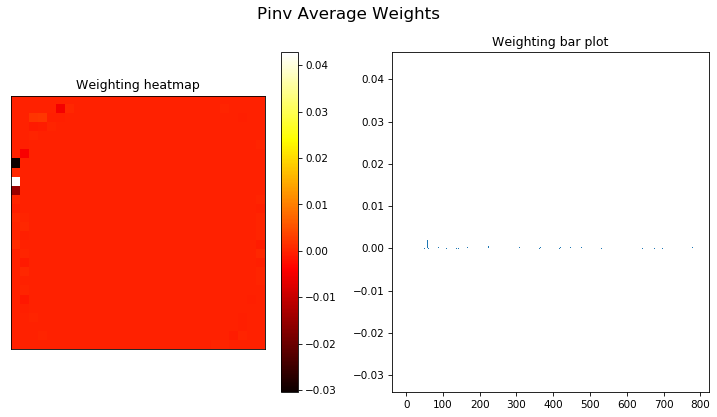

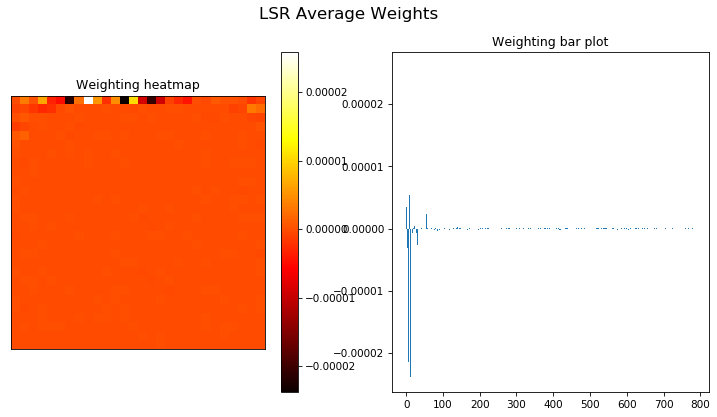

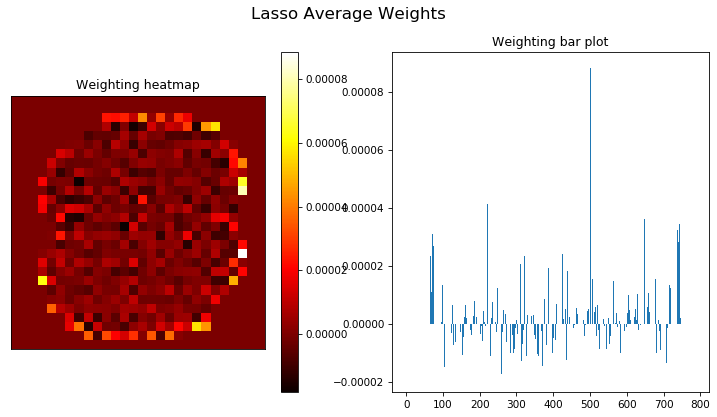

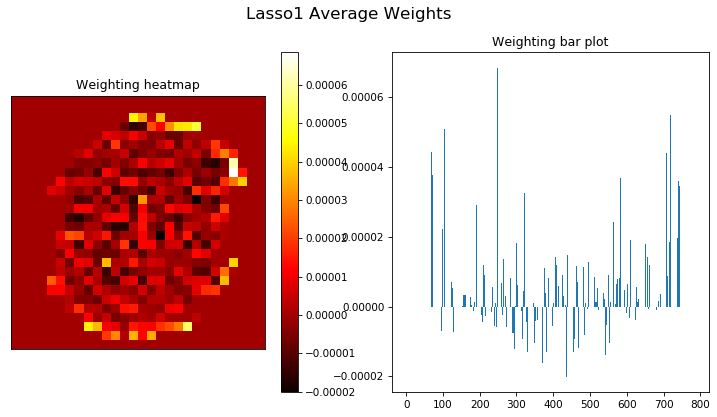

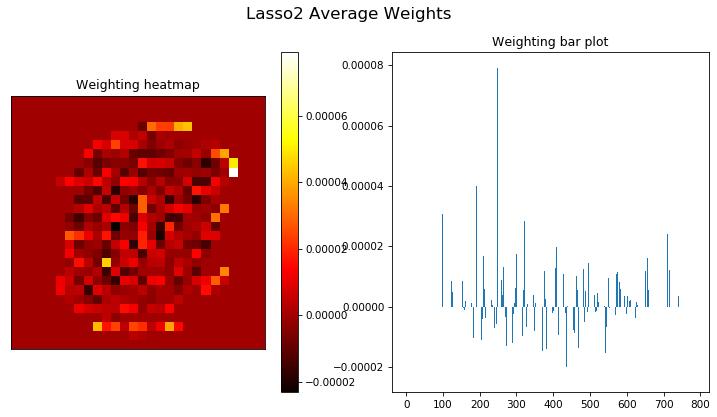

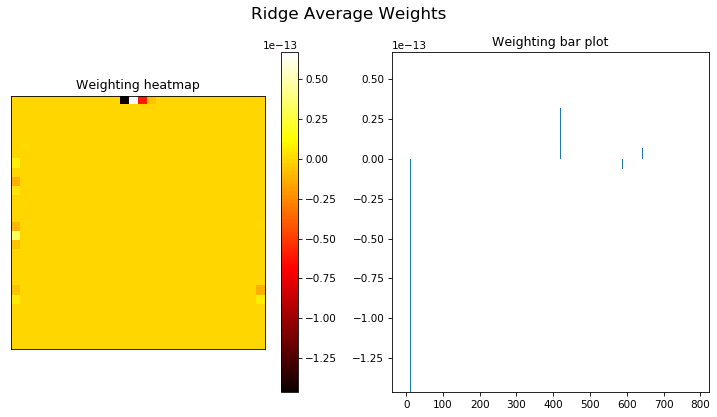

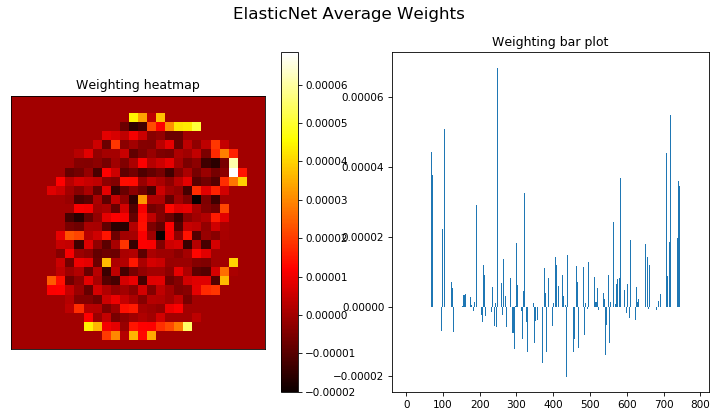

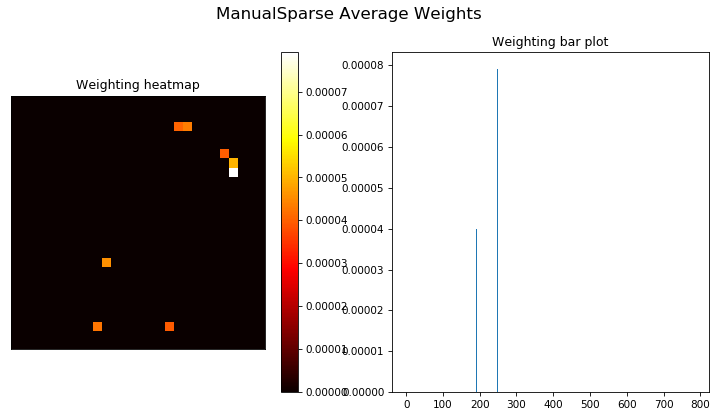

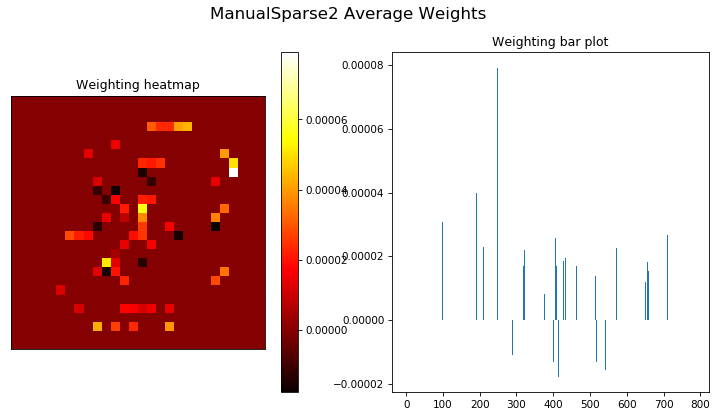

In [690]:
for model in modelResults:
    coeffs = modelResults[model]
    coeffs = np.mean(coeffs, axis = 0)
    u = np.reshape(coeffs, (28,28))
    
    f,a = plt.subplots(1,2, figsize = (12,6), dpi = 75)
    f.suptitle(model+ " Average Weights",fontsize = 16)
    
    im = a[0].imshow(u,cmap = "hot", interpolation = 'none')    
    a[0].set_xticks([])
    a[0].set_yticks([])
    a[0].set_title("Weighting heatmap")
    
    a[1].bar(range(28**2),coeffs)
    a[1].set_title("Weighting bar plot")
    
    fig.colorbar(im, ax=a[0])
    
    plt.show()

We wish to reduce the sparsity even further to see how our model performs.

A larger magnitude in the model means the digit is more important for recognition. Using the lasso as a starting point (with alpha = 1, as this choice of alpha promotes the most sparsity), we choose just the most important pixels (defined to be within 50% of the maximal pixel weighting. Choosing a stricter criteria, i.e. 80%, will cause only one pixel total to be chosen). We create a matrix where this is the weighting for each digit. The weighting (which is the same for each digit) is plotted below.

The pixels plotted are what we deem to be the most important pixels for digit recognition, on average. They are ranked by magnitude, evident in the heatmap (white has the highest importance, while dark red has the lowest).

In [623]:
sparseModelChoice = modelResults["Lasso2"]

ls = np.mean(sparseModelChoice, axis = 0)

mx = max(np.abs(ls))

importantPixels = []

ip = [value if abs(value) > mx*0.5 else 0 for value in ls]

importantPixels.append(ip)

X8 = np.array([importantPixels[0] for i in range(10)])

modelResults["ManualSparse"] = X8

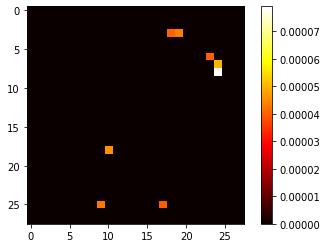

In [624]:
u = np.reshape(importantPixels, (28,28))
plt.imshow(u,cmap = "hot", interpolation = 'nearest')
plt.colorbar()
plt.show()

## 3. Apply your most important pixels to the test data set to see how accurate you are with as few pixels as possible.

First, we compute the sparsities and the scores of each digit on the test data. The results are plotted below. From the plots, it's clear that the pseudo-inverse, least squares with no penalization, and ridge regression are significantly less sparse than the lasso, elastic net, and our manually-reduced sparsity model. 

The manually-reduced sparsity model is the most sparse, which is reasonable as we pared down the sparsity even further from the most-sparse lasso model (with the highest value of the parameter alpha). This model, however, performs terribly compared to the rest. This is to be expected. The weightings for each digit was set to be exactly the same, meaning there is no real way to differentiate between digits. As a result, the model guesses that each digit is equally likely, and as the default guess is the digit 1, the accuracy is only about 10%, as the digit 1 accounts for approximately 10% of the test data. An adaptation of this very sparse model will be more interesting when we repeat the analysis for each digit in the next section.

As for the other models, the pseudo-innverse has the highest accuracy, followed closely by regular least squares and ridge regression. The lasso and elastic net perform similarly to each other but slightly worse than the others. As the penalty (alpha) increases for the lasso, driving up the sparsity, the accuracy of the model decreases slightly. The changes in percent sparsity are relatively large, while the increase in error is not enormous. 

Studying these models highlights some of their benefits and drawbacks. The lasso and elastic net are interpretable models, but that interpretability also comes with a higher error (with this data set, at least). The pseudo-inverse is the most accurate, but it is not at all interpretable, appearing very random. There's some tradeoff between interpretability and accuracy, so a model should be chosen carefully based on the modeler's priorities. 

In [625]:
scores = []
sparsities = []
models = []
for model in modelResults:
    scores.append(scoreModel(A_test,B_test,modelResults[model]))
    sparsities.append(sparsityScore(modelResults[model]))
    models.append(model)

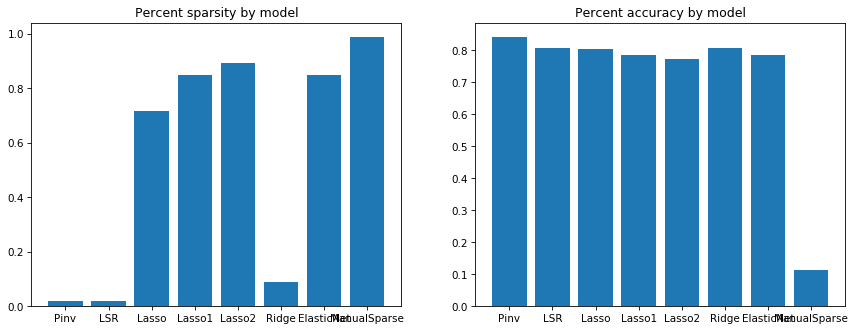

In [626]:
fig1, ax1 = plt.subplots(1,2, figsize = (14,5),dpi= 75)

x=np.arange(len(models));

ax1[0].bar(x,sparsities);
ax1[0].set_title("Percent sparsity by model")
ax1[0].set_xticks(x);
ax1[0].set_xticklabels(models);


ax1[1].bar(x,scores);
ax1[1].set_title("Percent accuracy by model")
ax1[1].set_xticks(x);
ax1[1].set_xticklabels(models);

Here we plot model sparsity versus model accuracy. There is a tendancy for accuracy to decrease as sparsity increases. The outlier with nearly 100% sparsity but very low accuracy is our manually produced sparsity model.

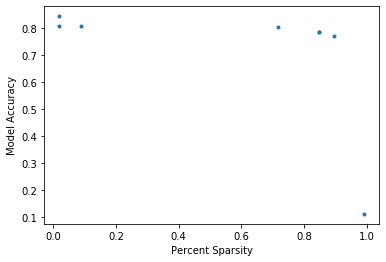

In [629]:
plt.plot(sparsities,scores,'.')
plt.xlabel("Percent Sparsity")
plt.ylabel("Model Accuracy")
plt.show()

## 4. Redo the analysis with each digit individually to find the most important pixels for each digit.

We perform the same analysis to manually manually increase the sparsity of the coefficients matrix, but this time we examine each row (with weightings for each digit) separately. 

We then compare sparsities of each row in the coefficient matrix (with each row corresponding to weightings for a digit) as well as scores for each percentage of digits guessed correctly.

In [442]:
# A function to find model accuracy by digit
def scoreModelByDigit(A_test,B_test,X):
    
    R1 = np.matmul(A_test,np.transpose(X))
    RR1 = np.zeros((R1.shape[0],R1.shape[1]),dtype=int)

    for k in range(R1.shape[0]):
        r = R1[k,:]
        index, value = max(enumerate(r), key=operator.itemgetter(1))
        r = np.zeros(10,dtype=int)
        r[index] = int(1)
        RR1[k,:] =r

    noCorrect = np.zeros(10,dtype = int)
    noIncorrect = np.zeros(10,dtype = int)
    total = np.zeros(10,dtype = int)

    for i in range(RR1.shape[0]):
        
        digitNo = np.where(B_test[i,:]==1)[0][0]
        test = RR1[i,:]+B_test[i,:]

        if max(test) != 2:
            noIncorrect[digitNo]+=1
        else:
            noCorrect[digitNo] +=1
    
        total[digitNo] += 1
        
    percentCorrect = noCorrect/total
    return percentCorrect  

In [678]:
# A function to find the sparsity in the vector corresponding to weightings for each digit.
def sparsityScoreByDigit(coeffs):
    score = np.zeros(10)
    for k in range(10):
        score[k] = sparsityScore(coeffs[k,:])
    return score

Now we manually reduce sparsity for each digit. We start with the lasso (with a highest penalty studied of alpha = 1). For each row in the matrix (as each row corresponds to weightings for a digit), we find the maximum value and keep values with magnitudes within 50% of that maximum. The resulting weightings for each digit are plotted below.

The heatmaps can be interpreted to display (and rank) the most important digits per pixel. A larger magnitude means the pixel will have more weight in digit categorization. White digits are thus the most important, and dark red pixels are relatively less important. All the other pixels are set to zero and are not significant enough to be included in the ranking.

In [656]:
sparseModelChoice = modelResults["Lasso2"]

X9 = []
for i in range(10):
    ls = sparseModelChoice[i,:]
    mx = max(np.abs(ls))
    ip = [value if abs(value) > mx*0.5 else 0 for value in ls]
    
    X9.append(ip)

X9 = np.array(X9)

modelResults["ManualSparse2"] = X9

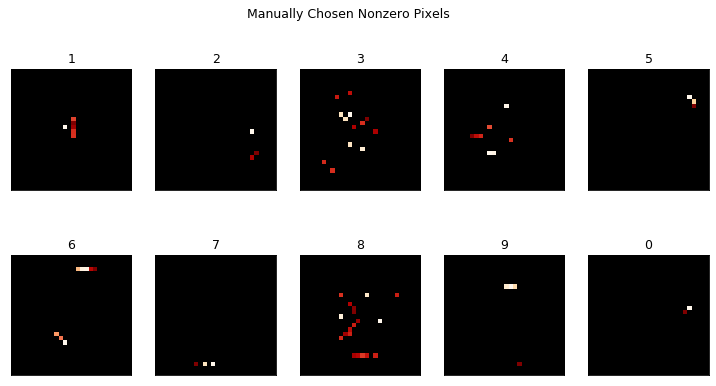

In [670]:
labels1 = ["1","2","3","4","5"]
labels2 = ["6","7","8","9","0"]

figS, axS = plt.subplots(2,5, figsize = (12,6), dpi = 75)

figS.suptitle("Manually Chosen Nonzero Pixels")

for i in range(5):

    u = np.reshape(X9[i,:], (28,28))
    u = np.ma.masked_where(u == 0, u)
    cmap = plt.cm.OrRd
    cmap.set_bad(color='black')
    axS[0,i].imshow(u,cmap = cmap, interpolation = 'none')
    
    u = np.reshape(X9[i+5,:], (28,28))
    u = np.ma.masked_where(u == 0, u)
    cmap = plt.cm.OrRd
    cmap.set_bad(color='black')
    axS[1,i].imshow(u,cmap = cmap, interpolation = 'none')
    
    axS[1,i].set_xticks([])
    axS[0,i].set_xticks([])
    axS[1,i].set_yticks([])
    axS[0,i].set_yticks([])
    
    axS[0,i].set_title(labels1[i])
    axS[1,i].set_title(labels2[i])
    
plt.show()


Now we will take a look at what models produce for each individual digit. We will choose the digit 4 as an example to study.

Plotting the weightings for a single digit emphasizes how the $l_1$ norm promotes both sparsity *and* interpretability: the weightings for the lasso and elastic net (the only models with $l_1$ penalty) resemble a hand-written 4. The other models have no clear structure.

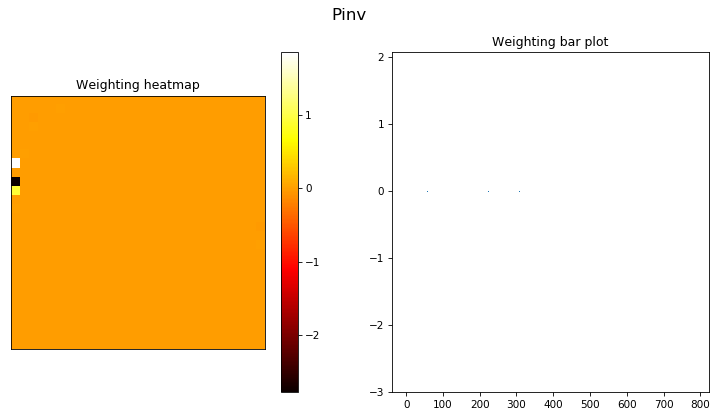

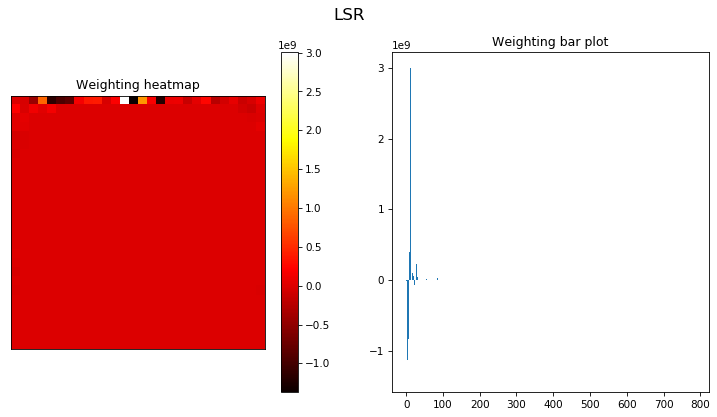

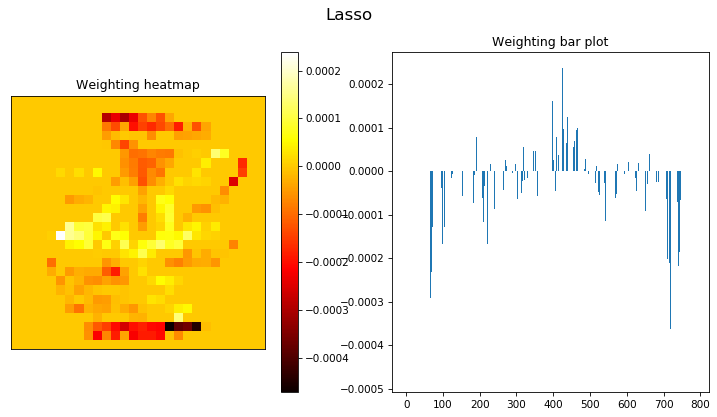

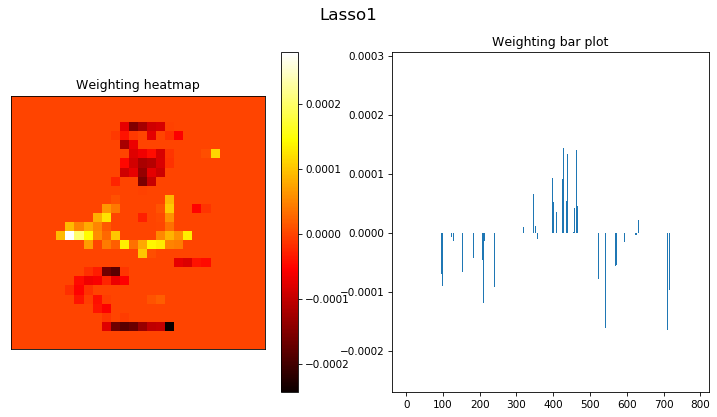

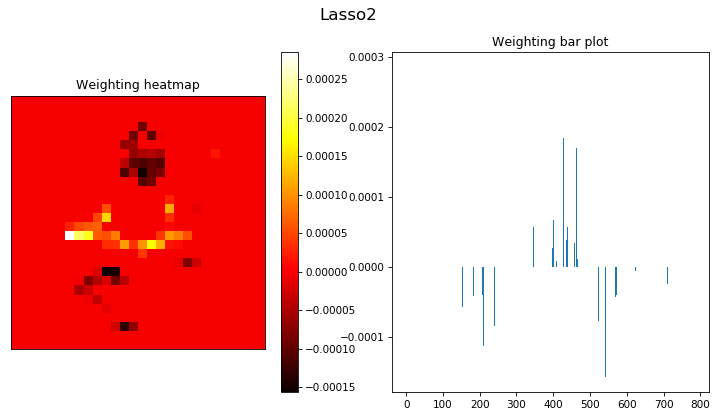

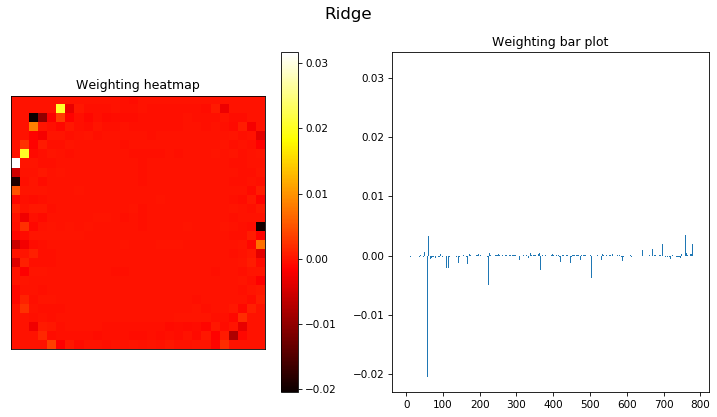

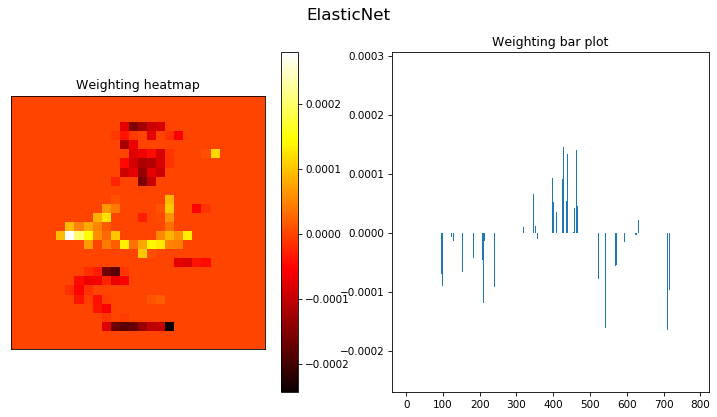

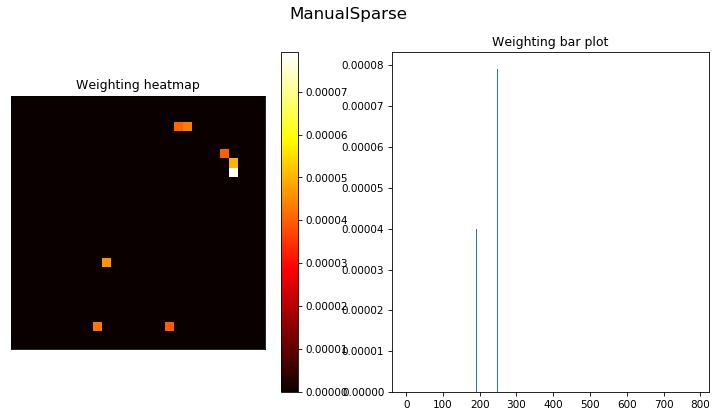

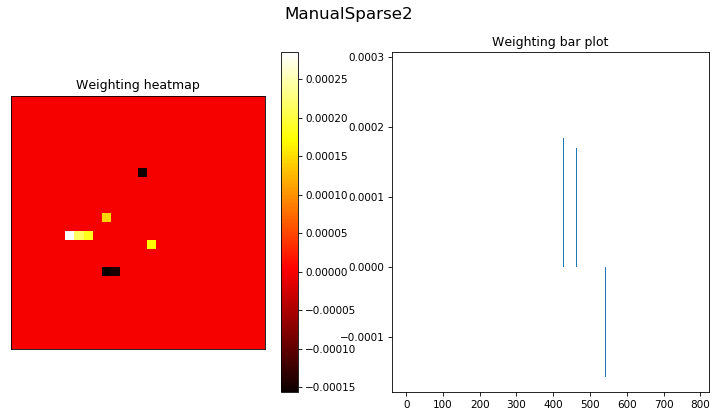

In [689]:
for model in modelResults:
    coeffs = modelResults[model]
    coeffs = coeffs[3,:]
  
    u = np.reshape(coeffs, (28,28))
    
    f,a = plt.subplots(1,2, figsize = (12,6), dpi = 75)
    f.suptitle(model,fontsize = 16)
    
    im = a[0].imshow(u,cmap = "hot", interpolation = 'none')    
    a[0].set_xticks([])
    a[0].set_yticks([])
    a[0].set_title("Weighting heatmap")
    
    a[1].bar(range(28**2),coeffs)
    a[1].set_title("Weighting bar plot")
    
    fig.colorbar(im, ax=a[0])
    
    plt.show()

Now we score each of the models by digit. Below we plot the sparsity and the model accuracy per digit for each model tested.

Studying the results, we immediately notice that each model performs most poorly for the digit four. This indicates that more training data may be necessary to properly train the model to detect and classify this digit. It is interesting to note that as the $l_1$ penalty increases in the lasso model, its ability to correctly classify the digit 4 suffers the most. Only the pseudo-inverse has success classifying 4 comparable to the other digits. 

There are a few interesting models to compare. For example, ridge regression has similar error across digits to Lasso2 (the model with the highest $l_1$ penalty even though its sparsity is much less. It is also interesting to note the differences between the first manually-produced sparse matrix (where the weightings for each digit were the same) and the manually-produced sparse matrix with unique weightings for unique digits. The sparsities are very similar (nearly 100%), but the latter model has a significantly higher accuracy. 

Examining the first manually-produced sparse matrix again confirms that the model is labeling all digits as 1, which is the default choice when each digit has equal probability under the model.

Examining the second (more accurate) manually-produced sparse matrix reveals that it does much better for some digits than others. It labels the digits 1, 6, and 8 relatively well, but fails to categorize 2 almost entirely. 

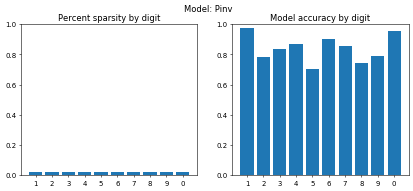

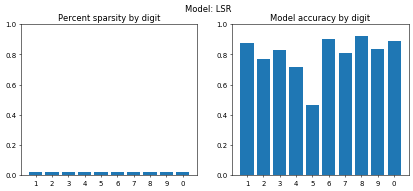

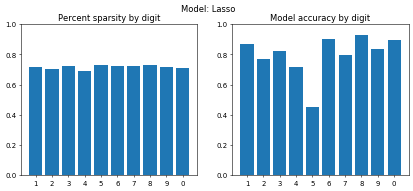

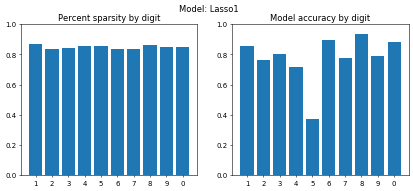

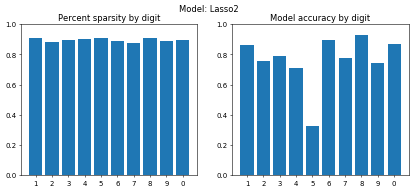

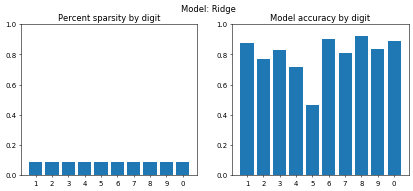

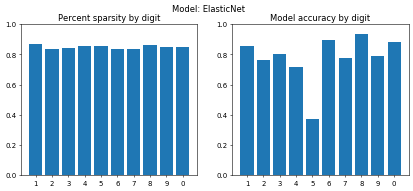

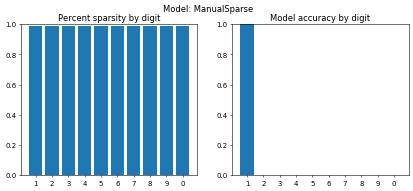

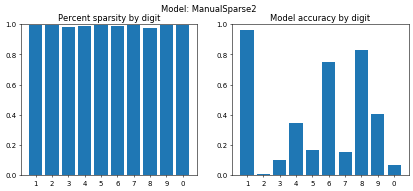

In [679]:
for model in modelResults:
    fig, ax = plt.subplots(1,2,figsize = (10,4), dpi =50)
    
    fig.suptitle("Model: "+ model)
    ax[0].bar(range(10), sparsityScoreByDigit(modelResults[model]))
    ax[1].bar(range(10), scoreModelByDigit(A_test,B_test,modelResults[model]))
    ax[0].set_title("Percent sparsity by digit")
    ax[0].set_ylim(0,1)
    ax[0].set_xticks(np.arange(10))
    ax[0].set_xticklabels(["1","2","3","4","5","6","7","8","9","0"])
    ax[1].set_title("Model accuracy by digit")
    ax[1].set_ylim(0,1)
    ax[1].set_xticks(np.arange(10))
    ax[1].set_xticklabels(["1","2","3","4","5","6","7","8","9","0"])
    
plt.show()

## 5. Think about the interpretation of what you're doing with this $\mathbf{A}\mathbf{X} = \mathbf{B}$ problem.

In all of the models produced, we found a matrix $\mathbf{X}$ that provides a mapping from the image space to the label space. This matrix has 10 rows each containing 784 columns. Each row corresponds to one digit, which is described with 784 pixels. Thus each row can be thought of as a vector of weights for each pixel, with higher magnitudes indicating a more important pixel to digit categorization.

In this assignment, in finding the mapping $\mathbf{X}$ we were particularly interested in promoting sparsity, which is done by promoting an $l_1$ penalty (here we used the lasso and elastic net). Models with a higher penalty have more pixel weights set to zero, resulting in a sparse matrix overall with only the most important pixels having nonzero weights. This lends interpretability, which we saw when plotting the weights for each digit (the weightings start to look like the hand-written digits). In studying the effects of the $l_1$ data set, we noted that the benefit of interpretability can be paired with increased error, indicating a potential tradeoff between interpretability and error when deploying these models.

Interestingly, the sparsity of the mapping matrix can be restricted to be quite high with still some notable success in categorizing digits. So while the mapping matrix $\mathbf{X}$ can be over 95% zeros, it can still categorize digits.

Finally, none of the models here produced accuracy rates for the whole data set over 90%. $\mathbf{A}\mathbf{X} = \mathbf{B}$ is a linear problem, and it is limited in that sense. To increase the accuracy of the dataset beyond what was accomplished with the pseudo-inverse, regular least-squares, the lasso, ridge regression, elastic net, and our manually-shrunk sparse matrices, more complex (nonlinear) models such as neural nets are required.